In [416]:
import pandas as pd
import numpy as np

import folium

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

import seaborn as sns

# Rental Data

In [417]:
#read in data set from https://www.kaggle.com/rajacsp/toronto-apartment-price
df_rent = pd.read_csv('datasets_72016_167007_Toronto_apartment_rentals_2018.csv')
df_rent.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,"$2,450.00"
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,"$2,150.00"
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,"$1,950.00"
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,"$2,900.00"
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,"$1,800.00"


In [418]:
#Convert price to float
df_rent['Price'] = df_rent['Price'].str.replace('$', '')
df_rent['Price'] = df_rent['Price'].str.replace(',', '')
df_rent['Price'] = df_rent['Price'].astype(float)

Examine the shape and contents of the dataset, and map locations to see what area they cover 

In [419]:
df_rent.shape[0]

1124

In [420]:
df_rent = df_rent.drop_duplicates()
df_rent.shape[0]

816

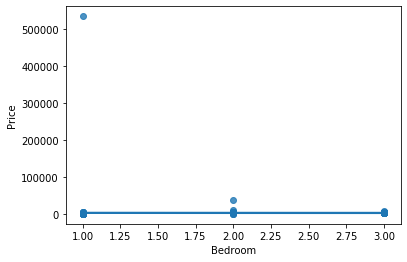

In [421]:
sns.regplot(df_rent['Bedroom'], df_rent['Price'])

The regression plot above shows that there is one price point that is significantly higher than the rest. Treat it as an outlier, and drop it:

In [422]:
df_rent = df_rent[df_rent['Price'] != df_rent['Price'].max()]

Replot the distrbution

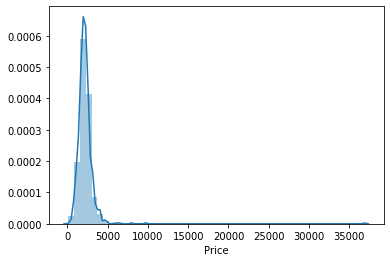

In [423]:
sns.distplot(df_rent['Price'])

The majority of the data is < 6000 so only keep data where the price is < 6000

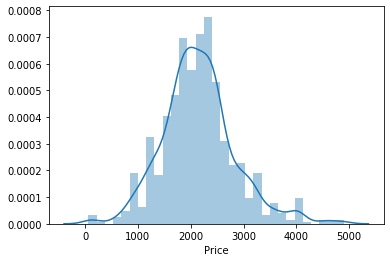

In [424]:
df_rent = df_rent[df_rent['Price'] < 6000]
sns.distplot(df_rent['Price'])

## Visualize the data

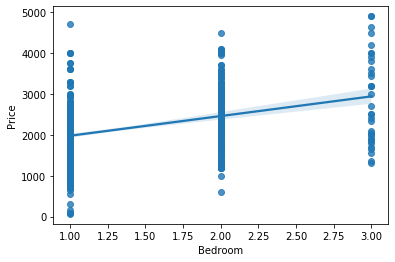

In [425]:
sns.regplot(df_rent['Bedroom'], df_rent['Price'])

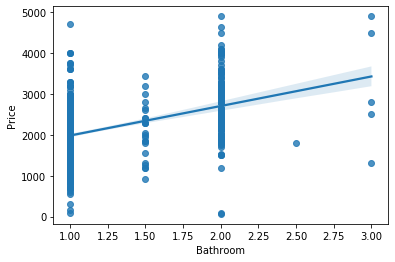

In [426]:
sns.regplot(df_rent['Bathroom'], df_rent['Price'])

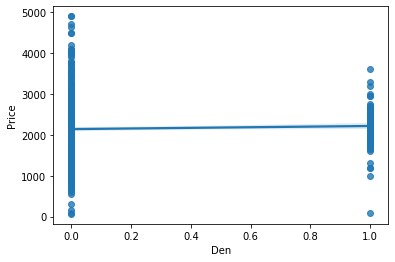

In [427]:
sns.regplot(df_rent['Den'], df_rent['Price'])

In [428]:
#Get coordinates of Toronto city centre
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="TO_explorer")
location = geolocator.geocode(address)
TO_latitude = location.latitude
TO_longitude = location.longitude
print(TO_latitude, TO_longitude)

43.6534817 -79.3839347


In [429]:
#map data set on map of Toronto
rent_map = folium.Map(location = [TO_latitude, TO_longitude], zoom_start = 6)
for lat, lng, address in zip(df_rent['Lat'], df_rent['Long'], df_rent['Address']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        parse_html = False).add_to(rent_map)
rent_map

The map above shows that some of the addresses in the dataset are as far away as Montreal. We are only interested in apartments in Toronto, so we will only consider addresses with postal codes in Toronto. Toronto postal codes can be retrieved from the Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M:

In [430]:
postal_codes = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df_post_code = postal_codes[0]

#Consider Toronto postal codes as only those where the borough contains 'Toronto'
df_post_code_TO = df_post_code[df_post_code['Borough'].str.contains('Toronto')]
df_post_code_TO.head()

,Postal Code,Borough,Neighborhood
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
13,M5B,Downtown Toronto,"Garden District, Ryerson"
22,M5C,Downtown Toronto,St. James Town
30,M4E,East Toronto,The Beaches


In [431]:
#Add postal code column to df_rent by extracting first 3 characters of postal code based on alphanumeric pattern
df_rent['Postal Code'] = df_rent['Address'].str.extract('([A-Z][0-9][A-Z])')
df_rent.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price,Postal Code
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0,L5B
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0,M5V
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0,M5B
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0,M5J
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0,M5T


In [432]:
#Modify dataframe to only keep postal codes that are in Toronto
df_rent = df_rent[df_rent['Postal Code'].isin(df_post_code_TO['Postal Code'])]
print('The rent dataframe now contains:', df_rent.shape[0], 'rows')

The rent dataframe now contains: 555 rows


Now that the dataset has been reduced to only addresses in Toronto, we will map them again to visualize the remaining data:

In [433]:
rent_map = folium.Map(location = [TO_latitude, TO_longitude], zoom_start = 6)
for lat, lng, address in zip(df_rent['Lat'], df_rent['Long'], df_rent['Address']):
    label = '{}'.format(address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        parse_html = False).add_to(rent_map)
rent_map

# Neighborhood Clusters

In [434]:
coordinates = df_rent[['Lat', 'Long']]
kclusters = 10
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(coordinates)
clusters = pd.DataFrame({'Latitude' : kmeans.cluster_centers_[:,0], 'Longitude' : kmeans.cluster_centers_[:,1]})
clusters.index.rename('Cluster Label', inplace = True)
clusters

,Latitude,Longitude
Cluster Label,,
0,43.639676,-79.424961
1,56.130366,-106.346771
2,43.646353,-79.377819
3,43.657597,-79.359742
4,43.641468,-79.398041
5,43.664995,-79.381376
6,43.681909,-79.406111
7,43.663449,-79.437923
8,43.674024,-79.300248


The dataframe above shows the coordinates of cluster 1 are significantly different than the others. Let's examine that cluster further

In [435]:
df_rent['Cluster'] = kmeans.labels_
df_rent[df_rent['Cluster'] == 1]

,Bedroom,Bathroom,Den,Address,Lat,Long,Price,Postal Code,Cluster
270,3,2.0,0,"M5B0A5, Canada",56.130366,-106.346771,4000.0,M5B,1
1023,1,1.0,1,"M4Y0C4, Canada",56.130366,-106.346771,1830.0,M4Y,1


It can be seen that although the two entries for cluster 1 have Toronto postal codes, they are clearly not in Toronto and therefore we will drop them and then re-run the kmeans clustering

In [436]:
df_rent = df_rent[df_rent['Cluster'] != 1]

In [437]:
coordinates = df_rent[['Lat', 'Long']]
kclusters = 10
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(coordinates)
clusters = pd.DataFrame({'Latitude' : kmeans.cluster_centers_[:,0], 'Longitude' : kmeans.cluster_centers_[:,1]})
clusters.index.rename('Cluster Label', inplace = True)
clusters

,Latitude,Longitude
Cluster Label,,
0,43.648388,-79.391511
1,43.663595,-79.434121
2,43.656040,-79.362465
3,43.664857,-79.381363
4,43.674024,-79.300248
5,43.645485,-79.379417
6,43.639697,-79.425615
7,43.640382,-79.399147
8,43.681909,-79.406111


In [438]:
#add cluster label to each row
df_rent['Cluster'] = kmeans.labels_

In [439]:
map_clusters = folium.Map(location = [TO_latitude, TO_longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_rent['Lat'], df_rent['Long'], df_rent['Address'], df_rent['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

# Foursquare Data

We would like to explore some of the local venues using Foursquare API data.

In [440]:
CLIENT_ID = '3SIYIZBQG2BXTRIEZZILYRN3RMSYH30DVPJETQHMGVUKOONB'
CLIENT_SECRET = 'F3EZXIVLTMM21RS2TSH3LVIPMWWVJYP1ACQCS3XUWCU1BDS4'
VERSION = '20180605'

In [441]:
def getNearbyVenues(names, latitudes, longitudes, radius = 2000):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cluster', 
                  'Cluster Latitude', 
                  'Cluster Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [442]:
LIMIT = 100
venues = getNearbyVenues(names = clusters.index, latitudes = clusters.Latitude, longitudes = clusters.Longitude)

0
1
2
3
4
5
6
7
8
9


In [443]:
venues.head()

,Cluster,Cluster Latitude,Cluster Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,43.648388,-79.391511,Pai,43.647923,-79.388579,Thai Restaurant
1,0,43.648388,-79.391511,Byblos Toronto,43.647615,-79.388381,Mediterranean Restaurant
2,0,43.648388,-79.391511,YYoga,43.649725,-79.391983,Yoga Studio
3,0,43.648388,-79.391511,TIFF Bell Lightbox,43.646342,-79.390063,Movie Theater
4,0,43.648388,-79.391511,Alo,43.648574,-79.396243,French Restaurant


In [444]:
#see all of the unique venue categories that are returned
venues['Venue Category'].unique()

array(['Thai Restaurant', 'Mediterranean Restaurant', 'Yoga Studio',
       'Movie Theater', 'French Restaurant', 'Cosmetics Shop', 'Diner',
       'Restaurant', 'Vegetarian / Vegan Restaurant', 'Smoke Shop',
       'Optical Shop', 'Sandwich Place', 'Dessert Shop',
       'Arts & Crafts Store', 'Coffee Shop', 'Food & Drink Shop',
       'Record Shop', 'Café', 'Art Gallery', 'Clothing Store',
       'Seafood Restaurant', 'Pizza Place', 'Neighborhood',
       'Ice Cream Shop', 'Bar', 'Street Art', 'Mexican Restaurant', 'Spa',
       'Scenic Lookout', 'Monument / Landmark', 'Brewery', 'Plaza',
       'Hotel', 'Park', 'Gym / Fitness Center', 'Italian Restaurant',
       'Bakery', 'Aquarium', 'Train Station', 'Baseball Stadium',
       'Organic Grocery', 'Gym', 'American Restaurant', 'Theater',
       'Dumpling Restaurant', 'Sporting Goods Shop', 'Cheese Shop',
       'Museum', 'Bubble Tea Shop', 'Tea Room', 'Basketball Stadium',
       'Performing Arts Venue', 'Pub', 'Food Court', 'Garden'

In [445]:
keywords = 'Restaurant|Joint|Place|Spot|Coffee Shop' #keywords that capture the majority of restaurants

#count how many restaurants per cluster
restaurants = venues[venues['Venue Category'].str.contains(keywords)].groupby('Cluster').count()['Venue']

In [446]:
#add restaurant data to rent dataframe
df_rent = df_rent.merge(restaurants, how = 'left', left_on = 'Cluster', right_on = 'Cluster')
df_rent = df_rent.rename(columns = {'Venue': 'Restaurants'})

# Distance to Centre

It is expected that the closer a rental is to city centre, the more expensive it will be. Therefore, we'll use geopy geodesic distance to determine how far away each rental is from the city centre and add it in a column of our rental dataframe

In [447]:
def distance_to_TO_centre(row):
    centre = (TO_latitude, TO_longitude)
    coord2 = (row['Lat'], row['Long'])
    return geodesic(centre, coord2).km

df_rent['Distance to Centre'] = df_rent.apply(distance_to_TO_centre, axis = 1)

Explore whether price is higher closer to city centre as expected

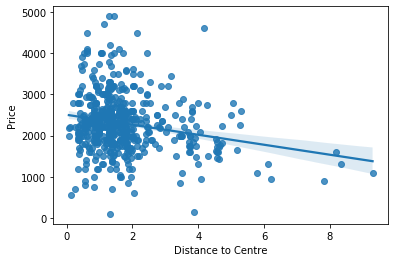

In [448]:
sns.regplot(df_rent['Distance to Centre'], df_rent['Price'])

# Regression

In [449]:
x = df_rent[['Bedroom', 'Bathroom', 'Den', 'Restaurants', 'Distance to Centre']] 
y = df_rent['Price']

#split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [450]:
#test different order polynomials to see which returns the highest R^2 value
lr = LinearRegression()
R_sq = []
order = [1,2,3]
for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    lr.fit(x_train_pr, y_train)
    R_sq.append(lr.score(x_test_pr, y_test))
R_sq

[0.3635447623119683, 0.3386588391479094, -7.845957902239579]

Text(0, 0.5, 'R^2')

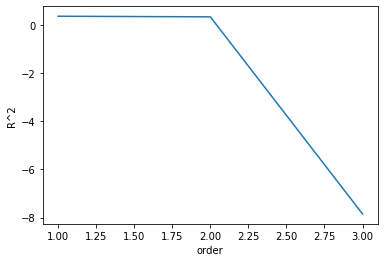

In [451]:
plt.plot(order, R_sq)
plt.xlabel('order')
plt.ylabel('R^2')

A first order polynomial results in the highest R^2 value, therefore there is no need to use fit_transform and we can perform straight linear regression

In [452]:
lr.fit(x_train, y_train)
yhat = lr.predict(x_test)


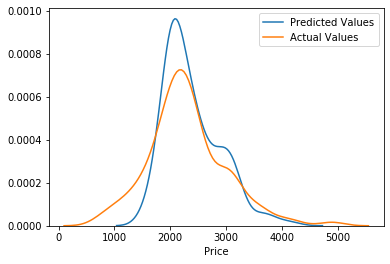

In [453]:
#Examine the distribution of predicted versus actual
sns.distplot(yhat, hist = False, label = 'Predicted Values')
sns.distplot(y_test, hist = False, label = 'Actual Values')

In [454]:
#return the coefficients of the model
coeff_df = pd.DataFrame(lr.coef_, x.columns, columns=['Coefficient'])  
print('Intercept =', lr.intercept_)
coeff_df

Intercept = 1497.9666539982945


,Coefficient
Bedroom,548.174387
Bathroom,492.853597
Den,367.307791
Restaurants,-13.361456
Distance to Centre,-71.444321
